# Boxscore and game level data collection

This notebook retrieves weekly team box score data for games. It expands nested structures into a clean tabular format and organizes statistics for both teams in a single row.

In [ ]:
from IPython.display import display
import pandas as pd
from games import (
    get_games,
    get_games_team_box,
    get_player_stats,
    get_game_weather,
    get_team_records,
)
import numpy as np
from credentials import API_KEY

### Boxscore Data collection

In [ ]:
all_weeks_data = []

for year in [2024, 2023]:  # multiple years
    for week in range(1, 18):  # Weeks 1-13
        week_data = get_games_team_box(year=year, week=week, classification="fbs")

        for game in week_data:
            game["year"] = year
            game["week"] = week

        all_weeks_data.extend(week_data)

df_team_stats = pd.DataFrame(all_weeks_data)

# Display column names for verification
print("\nTeam Box Scores Columns:")
print(df_team_stats.columns.tolist())

# Display first few rows
display(df_team_stats.head())

In [ ]:
# Display column names
print("\nTeam Box Scores Columns (2024):")
print(df_team_stats.columns.tolist())
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)
pd.set_option("display.max_colwidth", None)


df_team_stats

###### Expand data

In [ ]:
# clean category names
def stat_category_to_variable_name(category):
    return category.replace(" ", "_").replace("-", "_").replace("/", "_").lower()


games_data = []

# expand into one row
for game in all_weeks_data:
    teams = game.get("teams", [])

    if len(teams) != 2:
        continue

    game_row = {"game_id": game["id"], "year": game["year"], "week": game["week"]}

    for team in teams:
        prefix = team["homeAway"]  # 'home' or 'away'
        game_row[f"{prefix}_team"] = team["team"]
        game_row[f"{prefix}_conference"] = team["conference"]
        game_row[f"{prefix}_points"] = team["points"]

        for stat in team["stats"]:
            stat_name = f"{prefix}_{stat_category_to_variable_name(stat['category'])}"
            game_row[stat_name] = stat["stat"]

    games_data.append(game_row)

df_final = pd.DataFrame(games_data)

# columns are correctly ordered
column_order = ["game_id", "year", "week"] + [
    col for col in df_final.columns if col not in ["game_id", "year", "week"]
]
df_final = df_final[column_order]

display(df_final.head())

In [ ]:
display(df_final)

## Potential issue here:
Regular season is usually weeks 1-14. The CFB playoffs, bowl games, and confrence championship games are not considered as weeks but just as playoffs. This is causing the playoffs games to be pushed to week 1 when they actually happen at end of season.  

The API can be called with regular season, post season, or both, but when you call just the post season it does not have any weeks corresponding to it.


Should these games be removed because not every team plays these additional games?
However, these are when the best matchup occurs.  

Potentially, could seperate these by doing individual api calls for post season and regular season. Not sure how to organize after that 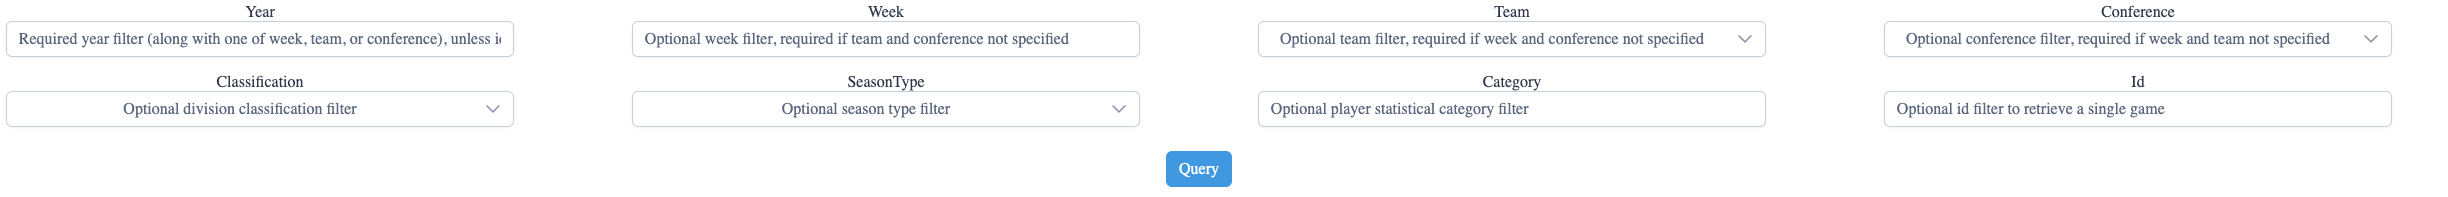


How much does week of a game matter?

https://collegefootballdata.com/exporter/games/teams

In [ ]:
fbs_conferences = [
    "SEC",
    "Big Ten",
    "ACC",
    "Pac-12",
    "Big 12",
    "American",
    "C-USA",
    "MAC",
    "MWC",
    "Sun Belt",
    "FBS Independents",
]

postseason_data = []

# Iterate over each conference to get postseason games
for conference in fbs_conferences:
    conf_postseason_data = get_games_team_box(
        year=2024, season_type="postseason", classification="fbs", conference=conference
    )

    if conf_postseason_data:
        postseason_data.extend(conf_postseason_data)

df_postseason = pd.DataFrame(postseason_data)

display(df_postseason)

39 post season games including bowl games, playoffs, and conference champs

## Game Information Data

Elo data and venue location is important here. (Neutural site)

In [ ]:
games_info = get_games(year=2024, session_type="regular", classification="fbs")
df_games = pd.DataFrame(games)

In [ ]:
display(df_games.head())

In [ ]:
keep_columns = [
    "id",
    "season",
    "week",
    "seasonType",
    "neutralSite",
    "conferenceGame",
    "homeTeam",
    "homeConference",
    "homePoints",
    "homePregameElo",
    "homePostgameElo",
    "awayTeam",
    "awayConference",
    "awayPoints",
    "awayPregameElo",
    "awayPostgameElo",
    "homePostgameWinProbability",
    "awayPostgameWinProbability",
]

df_games_filtered = df_games[keep_columns].copy()

display(df_games_filtered.head())